## 기본 내용

In [36]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')

device

device(type='cuda')

In [37]:
import torch_geometric
from torch_geometric.data import Data

그래프 신경망을 이용하여 예측을 수행할 때, 크게 3가지 레벨에서 예측을 수행할 수 있다.

1. 노드 수준: 목적값 y값의 개수가 각 노드의 개수와 동일함.  
2. 연결 수준: 목적값 y값의 개수가 연결의 개수와 동일함.
3. 그래프 수준: 하나의 그래프 전체에서 하나의 목적값을 예측함.

<img src="https://velog.velcdn.com/images%2Fhixkix59%2Fpost%2F4249de11-3726-4e44-a025-8edd47019365%2Fimage.png" width=600>

In [5]:
# Edge
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

# Edge 1: Connects node 0 to node 1 (source: 0, target: 1)
# Edge 2: Connects node 1 to node 0 (source: 1, target: 0)
# Edge 3: Connects node 1 to node 2 (source: 1, target: 2)
# Edge 4: Connects node 2 to node 1 (source: 2, target: 1)
# edge 방향 / 결합?을 행렬로 표시



# Node
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# 노드 0, 1, 2 번은 각각 -1, 0, 1 의 값을 갖는다.

data = Data(x=x, edge_index=edge_index)

data

Data(x=[3, 1], edge_index=[2, 4])

In [6]:
# edge index
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)

# node features
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

data

# 행렬을 t().contiguous() 사용해서 모양 바꿔줘야 함
# t() = 전환
# contiguous() = t() 사용하면 읽는 방향?이 뭐가 달라진다고 함 .. 그걸 맞춰주는것

Data(x=[3, 1], edge_index=[2, 4])

In [7]:
data.validate(raise_on_error=True)

True

In [8]:
# data 가 갖고있는 속성
print(data.keys)

# 노느 특성 출력
print(data['x'])

# Edge attribute 존재여부 확인
'edge_attr' in data

# 등등 다양하게 ..

['edge_index', 'x']
tensor([[-1.],
        [ 0.],
        [ 1.]])


False

In [9]:
# data 를 device 로 전달
data = data.to(device)

## rdkit + GCN

In [38]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric
from torch_geometric.data import Data

In [39]:
torch.manual_seed(921024)

In [40]:
import pandas as pd
import joblib
from tqdm import tqdm
import os

In [41]:
dock_res = pd.read_csv('Group_1_Enamine_ADGPU_dock.csv')

dock_res.head()

,description,score,SMILES
0,Z1735925907,-3.94,CC(C)CC1OCCCC1NC(=O)N1CCN(CC(=O)NC2CC2)CC1
1,Z1866885071,-5.27,CS(=O)(=O)c1ccc(CNC(=O)c2ccc[nH]2)cc1Cl
2,Z1756593424,-3.48,CCn1ccnc1[C@H]1OCC[C@@H]1NC(=O)COCC1CCCO1
3,Z28051659,-6.65,Cc1nn(Cc2ccccc2)c(C)c1C(=O)Nc1cccc(c1)n1cnnn1
4,Z1626370051,-5.04,Cn1cc(NC(=O)N2CCOC3(CCC3)C2)c(n1)c1ccccc1


In [16]:
dock_res.describe()

,score
count,426643.000000
mean,-5.270509
std,0.802191
min,-9.190000
25%,-5.810000
50%,-5.260000
75%,-4.730000
max,-1.370000


In [57]:
def check_atoms(mol):
    """
    This function checks whether all atoms are valid
    """
    valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I')
    flag = True
    for atm in mol.GetAtoms(): # 분자 안에 존재하는 모든 atom에 대해서 loop을 수행.
        if atm.GetSymbol() not in valid_atoms:
            flag = False
            break
            return flag

In [ ]:
ligand_data = []
for smi, score in tqdm(zip(dock_res['SMILES'], dock_res['score'])):
    mol = Chem.MolFromSmiles(smi)
    score = float(score)
    
    if check_atoms(mol):
        ligand_data.append((mol, score))
        
    else:
        print(f'{smi} has non-targeted atoms')
        
    continue
    
    
# Save mol-type variables.
joblib.dump(ligand_data, 'dock_res_data.joblib')

In [17]:
ligand_data = joblib.load('dock_res_data.joblib')

In [18]:
print(f"Number of data: {len(ligand_data)}")

Number of data: 426643


In [19]:
def convert_mol_to_graph(mol, use_pos = False):

        #mol2 = Chem.AddHs(mol)
        mol2 = Chem.RemoveHs(mol)

        n_bonds = len(mol2.GetBonds()) # 분자의 공유 결합 개수
        n_atoms = len(mol2.GetAtoms()) # 분자의 원자 개수

        node_attr = []
        #### node 속성 계산 시작 ####
        # RDKit으로 계산할 수 있는 Atom의 속성은 아래 링크에서 확인할 수 있다.
        # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
        #
        #.                0.     1.     2.     3.     4.     5.     6.     7.     8.        9.    10.
        #                'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl' 'Br'    'I'
        valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8, 'Br':9, 'I':10}

        for atm_id in range(n_atoms):
                # Select an atom.
                atm = mol2.GetAtomWithIdx(atm_id)

                # Atom symbol check (9-dim)
                sym = atm.GetSymbol()
                atm_one_hot = [0] * len(valid_atoms) # 0이 9개 들어있는 리스트를 만든다.
                idx = valid_atoms[sym] # sym에 해당하는 원소 기호가 몇 번째에 있는지?
                atm_one_hot[idx] = 1     # 해당되는 원소의 위치만 1로 바꾼다.

                # Check hybridization (7-dim)
                hybrid = atm.GetHybridization()
                hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
                if hybrid == Chem.HybridizationType.SP3:
                    hybrid_one_hot[0] = 1
                elif hybrid == Chem.HybridizationType.SP2:
                    hybrid_one_hot[1] = 1
                elif hybrid == Chem.HybridizationType.SP:
                    hybrid_one_hot[2] = 1
                elif hybrid == Chem.HybridizationType.S:
                    hybrid_one_hot[3] = 1
                elif hybrid == Chem.HybridizationType.SP3D:
                    hybrid_one_hot[4] = 1
                elif hybrid == Chem.HybridizationType.SP3D2:
                    hybrid_one_hot[5] = 1
                else: # hybridization이 제대로 정의되지 않은 나머지의 모든 경우.
                    hybrid_one_hot[6] = 1

                # aromatic 인지 아닌지?    (True/False)
                if atm.GetIsAromatic():
                    arom = 1
                else:
                    arom = 0

                # ring 안에 존재하는지 아닌지? (True/False)
                if atm.IsInRing():
                    ring_flag = 1
                else:
                    ring_flag = 0

                # Degree (공유 결합의 개수)    (6-dim, one-hot)
                # 0, 1, 2, 3, 4, >=5
                degree_one_hot = [0, 0, 0, 0, 0, 0]
                degree = atm.GetTotalDegree()
                if degree >= 5: # 5개 이상의 공유 결합을 가지는 원자.
                    degree_one_hot[5]=1
                else:
                    degree_one_hot[degree]=1

                # Number of hydrogens (5-dim, one-hot)
                # 결합되어 있는 수소의 개수.
                # 0, 1, 2, 3, >=4
                num_h = atm.GetTotalNumHs()
                hydrogen_one_hot = [0, 0, 0, 0, 0]
                if num_h >= 4:
                    hydrogen_one_hot[4] = 1
                else:
                    hydrogen_one_hot[num_h] = 1

                # Chirality (4-dim, one-hot)
                chiral = atm.GetChiralTag()
                if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
                    chiral_one_hot = [1, 0, 0, 0]
                # Counter-clock-wise (반시계)
                elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                    chiral_one_hot = [0, 1, 0, 0]
                # Clockwise (시계방향)
                elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
                    chiral_one_hot = [0, 0, 1, 0]
                # Chirality 정의되지 않음.
                elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                    chiral_one_hot = [0, 0, 0, 1]

                # 원자 특성 계산 [원자 symbol one-hot, 공유 결합 개수, 전체 valence의 개수 (explicit + implicit), is an atom aromatic (True/False)? ]
                # 더 추가 가능!
                # in total 25-dim.
                # 11-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
                attr = atm_one_hot + \
                                hybrid_one_hot + \
                                degree_one_hot + \
                                hydrogen_one_hot + \
                                chiral_one_hot + \
                                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

                #print(atm_id, attr)
                node_attr.append(attr)

        #### node 속성 계산 완료 ####

        edge_index = []
        edge_attr = []
        edge_weight = []
        for edge_idx in range(n_bonds): # 전체 공유 결합에 대해서 loop을 돌린다.

                bond = mol2.GetBondWithIdx(edge_idx) # 각 공유 결합에 대해서 시작 atom과 끝 atom의 인덱스를 확인.
                edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # undirected graph를 만들기 위해서 순서를 바꿔서 edge를 2번 넣어준다.

                # BondType (4-dimensional one-hot)
                btype = bond.GetBondType() # 공유 결합의 종류.
                if btype == Chem.rdchem.BondType.SINGLE:
                        bond_one_hot = [1, 0, 0, 0]
                        edge_weight.extend([1.0, 1.0])
                elif btype == Chem.rdchem.BondType.AROMATIC:
                        bond_one_hot = [0, 1, 0, 0]
                        edge_weight.extend([1.5, 1.5])
                elif btype == Chem.rdchem.BondType.DOUBLE:
                        bond_one_hot = [0, 0, 1, 0]
                        edge_weight.extend([2.0, 2.0])
                elif btype == Chem.rdchem.BondType.TRIPLE:
                        bond_one_hot = [0, 0, 0, 1]
                        edge_weight.extend([3.0, 3.0])

                # BondStereo (6-dimensional one-hot)
                stype = bond.GetStereo()
                if stype == Chem.rdchem.BondStereo.STEREOANY:
                    stereo_one_hot = [1, 0, 0, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOCIS:
                    stereo_one_hot = [0, 1, 0, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOE:
                    stereo_one_hot = [0, 0, 1, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREONONE:
                    stereo_one_hot = [0, 0, 0, 1, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
                    stereo_one_hot = [0, 0, 0, 0, 1, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOZ:
                    stereo_one_hot = [0, 0, 0, 0, 0, 1]

                # Is this bond included in a ring?
                if bond.IsInRing():
                    ring_bond = 1
                else:
                    ring_bond = 0

                # Is this bond a conjugated bond?
                if bond.GetIsConjugated():
                    conjugate = 1
                else:
                    conjugate = 0

                # In total 12-dimensional edge attribute
                # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
                # Can you image more?
                attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 차원의 공유 결합 속성.

                # 분자는 undirected graph이므로 edge가 두 번 정의된다.
                # 그러므로 동일한 attribute를 두 번 넣어주어야 한다.
                edge_attr.append(attr)
                edge_attr.append(attr)
        #### edge 속성 계산 완료 ####


        # PyTorch Tensor로 변환.
        edge_attr = torch.tensor(edge_attr, dtype = torch.float)
        node_attr = torch.tensor(node_attr, dtype = torch.float)
        edge_index = torch.tensor(edge_index, dtype = torch.long)
        edge_index = edge_index.t().contiguous()
        edge_weight = torch.tensor(edge_weight, dtype = torch.float)


        # 만일 3D 좌표 정보를 사용한다면
        if use_pos:
                val = AllChem.EmbedMolecule(mol2)
                if val !=0:
                    print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
                    return None

                pos_list = [] # this is optional
                for atm_id in range(n_atoms):
                    # Get Atomic Position.
                    atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
                    crd = [atm_pos.x, atm_pos.y, atm_pos.z]
                    pos_list.append(crd)

                pos = torch.tensor(pos_list, dtype=torch.float)
        else:
            pos = None
        #print(edge_attr.shape)
        #print(node_attr.shape)
        #print(edge_index.shape)

        return edge_index, node_attr, edge_attr, pos, edge_weight

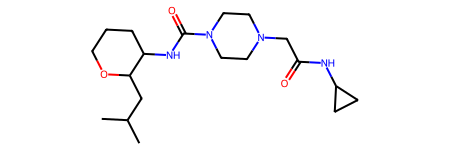

In [20]:
ligand_data[0][0]

In [21]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(ligand_data[0][0])


d0 = Data(x = x, 
          edge_index = edge_index, 
          edge_attr = edge_attr, 
          pos = pos, 
          edge_weight = edge_weight)

print (d0)

Data(x=[26, 37], edge_index=[2, 56], edge_attr=[56, 12], edge_weight=[56])


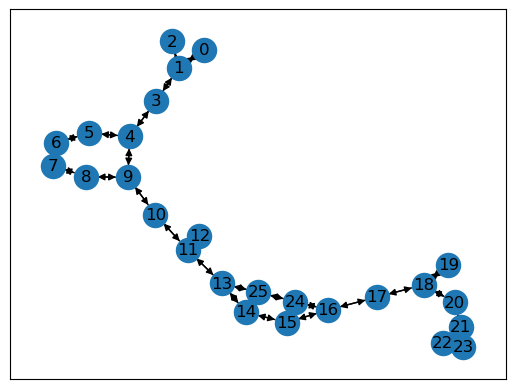

In [23]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx

G = to_networkx(d0)
nx.draw_networkx(G)

### PyG 의 data type 으로 분자들 변환하기

In [21]:
fname = 'dock_res_converted_graph.joblib'
data_list = []


for mol, score in tqdm(ligand_data):
    result = convert_mol_to_graph(mol)
    
    if result is None:
        continue
        
        
    edge_index, node_attr, edge_attr, pos, edge_weight = result
    
    y = torch.tensor([[score]], dtype=torch.float)
    
    dtmp = Data(x = node_attr, 
                edge_index = edge_index, 
                edge_attr = edge_attr, 
                edge_weight = edge_weight, 
                pos = pos, 
                y = y)
    
    # dtmp = 맨 위의 기초 부분에서, edge 와 node 를 정의한 다음
    # pyg Data 를 이용해서 만든것 (graph 정보를 담고있도록)
    # 이걸 data_list 에 하나씩 담는 과정
    data_list.append(dtmp)
    
    
joblib.dump(data_list, fname)
print ('saved')

 99%|████████████████████████████████▌| 420622/426643 [02:22<00:02, 2957.71it/s]


KeyboardInterrupt: 

In [24]:
fname = 'dock_res_converted_graph.joblib'
data_list = joblib.load(fname)

In [25]:
# torch geometric dataloader (일반 torch dataloader 와 유사)

from torch_geometric.loader import DataLoader
import random

random.seed(12345)
random.shuffle(data_list)
n_data = len(data_list)


train_set, val_set, test_set = data_list[:int(n_data*0.7)], data_list[int(n_data*0.7):int(n_data*0.8)], data_list[int(n_data*0.8):]

print(f"Number of training set: {len(train_set)}")
print(f"Number of Validaation set: {len(val_set)}")
print(f"Number of test set: {len(test_set)}")

node_features = data_list[0].num_node_features
print('node features: ', node_features)

Number of training set: 298650
Number of Validaation set: 42664
Number of test set: 85329
node features:  37


In [26]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last = False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, drop_last = False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, drop_last = False)

n_epoch = 100

In [27]:
# cound parameter 함수 정의 ???

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn.functional import gelu
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.nn import global_mean_pool

class myGCN(torch.nn.Module):
    def __init__(self, in_channel=35, hidden_layer_size=70):
        super().__init__()
        self.conv1 = GCNConv(in_channel, hidden_layer_size) 
        # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.bn1 = BatchNorm(hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn2 = BatchNorm(hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn3 = BatchNorm(hidden_layer_size)

        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        #self.lin1_bn = BatchNorm(int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.gelu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.gelu(x)

        # READOUT
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x) # 70 dim -> 35-dim
        #x = self.lin1_bn(x)
        x = F.elu(x)

        x = self.lin2(x) # 35 dim -> 1-dim

        return x

In [29]:
model = myGCN(in_channel = node_features, hidden_layer_size = 70)
model.to(device)

myGCN(
  (conv1): GCNConv(37, 70)
  (bn1): BatchNorm(70)
  (conv2): GCNConv(70, 70)
  (bn2): BatchNorm(70)
  (conv3): GCNConv(70, 70)
  (bn3): BatchNorm(70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [30]:
print(model)

myGCN(
  (conv1): GCNConv(37, 70)
  (bn1): BatchNorm(70)
  (conv2): GCNConv(70, 70)
  (bn2): BatchNorm(70)
  (conv3): GCNConv(70, 70)
  (bn3): BatchNorm(70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)


In [31]:
count_parameters(model)

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|     conv1.bias    |     70     |
|  conv1.lin.weight |    2590    |
| bn1.module.weight |     70     |
|  bn1.module.bias  |     70     |
|     conv2.bias    |     70     |
|  conv2.lin.weight |    4900    |
| bn2.module.weight |     70     |
|  bn2.module.bias  |     70     |
|     conv3.bias    |     70     |
|  conv3.lin.weight |    4900    |
| bn3.module.weight |     70     |
|  bn3.module.bias  |     70     |
|    lin1.weight    |    2450    |
|     lin1.bias     |     35     |
|    lin2.weight    |     35     |
|     lin2.bias     |     1      |
+-------------------+------------+
Total Trainable Params: 15541


15541

In [32]:
device

device(type='cuda')

In [33]:
# test fn
def test(loader):
    model.eval()
    error = 0.0
    out_all = []
    true = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        tmp = (out - data.y)**2
        error += tmp.sum().item()  # Check against ground-truth labels.

        out_all.extend([x.item() for x in out])
        true.extend([x.item() for x in data.y])

    return error / len(loader.dataset), out_all, true  # Derive ratio of correct predictions.



# train fn
def train():
    for idx, batch in enumerate(train_loader):
        out = model(batch.to(device))
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()    # Update parameters based on gradients.
        optimizer.zero_grad()    # Clear gradients.
        if idx%100 == 0:
            lr = scheduler.get_last_lr()
            print(f"IDX: {idx:5d}\tLoss: {loss:.4f}\tLR:{lr}")
            
            
# define optimizer
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

#### Training


Learning rate 을 동적으로 조절하는 스케줄러 이용 (learning rate scheduler)


In [34]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

train_acc_list = []
val_acc_list = []

best_val_rmse = 9999.9

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
model.train()

for epoch in range(1, n_epoch):
        print("="*100)
        print("Epoch: ", epoch)

        train()
        scheduler.step()

        train_acc, out_tmp, true_tmp = test(train_loader)
        train_acc_list.append(train_acc)

        val_acc, val_pred, val_true = test(val_loader)
        val_acc_list.append(val_acc)

        # Save the best model
        if val_acc < best_val_rmse:
            best_epoch = epoch
            best_val_rmse = val_acc
            best_train_rmse = train_acc
            torch.save(model, "Best_GCN_model_v1.pt")

        print("-"*80)
        print(f'Epoch: {epoch:03d}, Train RMSE: {train_acc:.4f}, Val RMSE: {val_acc:.4f}')
        print("-"*80)
        print(f"Best Epoch: {best_epoch:03d}")
        print(f"Best val     RMSE: {best_val_rmse:.4f}")
        print(f"Best train RMSE: {best_train_rmse:.4f}")
        print('='*80)

Epoch:  1
IDX:     0	Loss: 28.7147	LR:[0.005]
IDX:   100	Loss: 0.4565	LR:[0.005]
IDX:   200	Loss: 0.6586	LR:[0.005]
IDX:   300	Loss: 0.3177	LR:[0.005]
IDX:   400	Loss: 0.5618	LR:[0.005]
IDX:   500	Loss: 0.1959	LR:[0.005]
IDX:   600	Loss: 0.3089	LR:[0.005]
IDX:   700	Loss: 0.4090	LR:[0.005]
IDX:   800	Loss: 0.3815	LR:[0.005]
IDX:   900	Loss: 0.4334	LR:[0.005]
IDX:  1000	Loss: 0.4823	LR:[0.005]
IDX:  1100	Loss: 0.5870	LR:[0.005]
IDX:  1200	Loss: 0.3388	LR:[0.005]
IDX:  1300	Loss: 0.3808	LR:[0.005]
IDX:  1400	Loss: 0.2813	LR:[0.005]
IDX:  1500	Loss: 0.3915	LR:[0.005]
IDX:  1600	Loss: 0.4351	LR:[0.005]
IDX:  1700	Loss: 0.2820	LR:[0.005]
IDX:  1800	Loss: 0.1533	LR:[0.005]
IDX:  1900	Loss: 0.4008	LR:[0.005]
IDX:  2000	Loss: 0.2466	LR:[0.005]
IDX:  2100	Loss: 0.2616	LR:[0.005]
IDX:  2200	Loss: 0.3358	LR:[0.005]
IDX:  2300	Loss: 0.3932	LR:[0.005]
IDX:  2400	Loss: 0.2540	LR:[0.005]
IDX:  2500	Loss: 0.3062	LR:[0.005]
IDX:  2600	Loss: 0.4204	LR:[0.005]
IDX:  2700	Loss: 0.5640	LR:[0.005]
IDX:  280

Test set RMSE: 0.1944 (ADGPU score)


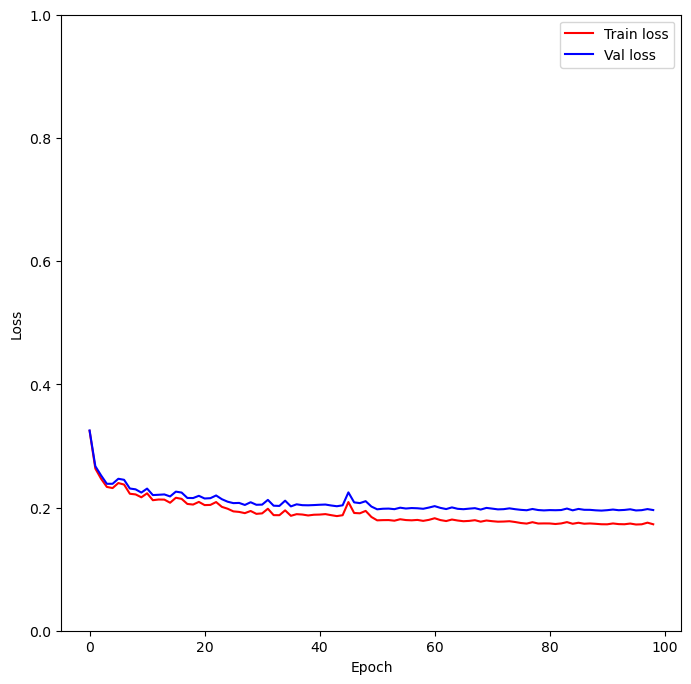

In [40]:
import matplotlib.pyplot as plt

def draw_loss_change(train_loss, val_loss):
    plt.figure(figsize=(8,8)) # 빈 그림을 정의
    plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
    plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
    #plt.plot(test_loss, color = 'g',    label = 'Test loss') # test set loss
    plt.ylim(ymin=0.0, ymax=1.0)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best') # label을 표시 하겠다.
    
    
draw_loss_change(train_acc_list, val_acc_list)


test_acc, out_all, true_all = test(test_loader)
print(f"Test set RMSE: {test_acc:.4f} (ADGPU score)")

Pearson R: 0.8372


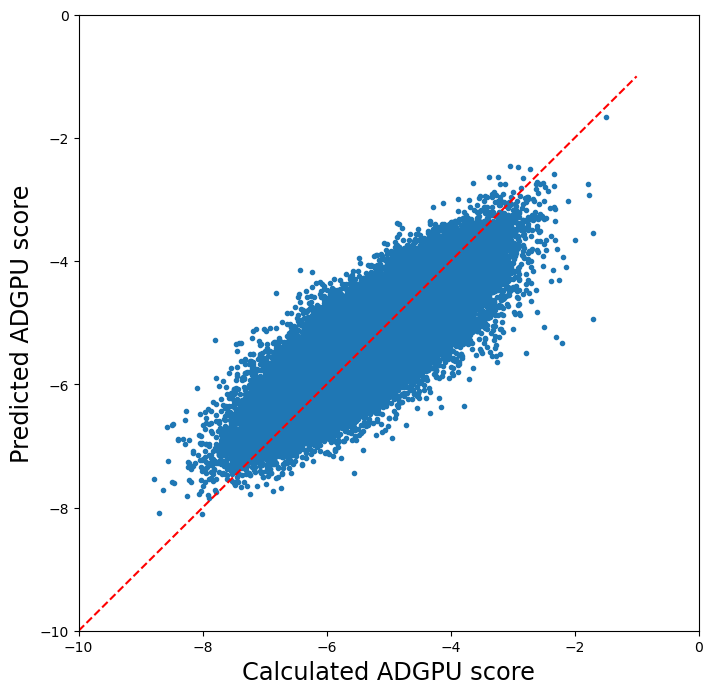

In [41]:
import matplotlib.pyplot as plt
#out_all = [x.detach().numpy() for x in out_all]
experimental = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(experimental, prediction, marker = '.')
plt.plot(range(-10, 0), range(-10, 0), 'r--')
plt.xlabel("Calculated ADGPU score", fontsize='xx-large')
plt.ylabel("Predicted ADGPU score", fontsize='xx-large')
plt.xlim(-10, 0)
plt.ylim(-10, 0)


corr = np.corrcoef(experimental, prediction)
print(f"Pearson R: {corr[0,1]:.4f}")

In [42]:
torch.save(model, "GCN_epoch_100.pt")

#### 모델 사용해서 값 예측하기

In [1]:
import torch
import numpy as np
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric
from torch_geometric.data import Data
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn.functional import gelu
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
import random
from tqdm import tqdm
import glob
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')


class myGCN(torch.nn.Module):
    def __init__(self, in_channel=35, hidden_layer_size=70):
        super().__init__()
        self.conv1 = GCNConv(in_channel, hidden_layer_size) 
        # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.bn1 = BatchNorm(hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn2 = BatchNorm(hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.bn3 = BatchNorm(hidden_layer_size)

        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        #self.lin1_bn = BatchNorm(int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.gelu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.gelu(x)

        # READOUT
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x) # 70 dim -> 35-dim
        #x = self.lin1_bn(x)
        x = F.elu(x)

        x = self.lin2(x) # 35 dim -> 1-dim

        return x

In [2]:
def convert_mol_to_graph(mol, use_pos = False):

        #mol2 = Chem.AddHs(mol)
        mol2 = Chem.RemoveHs(mol)

        n_bonds = len(mol2.GetBonds()) # 분자의 공유 결합 개수
        n_atoms = len(mol2.GetAtoms()) # 분자의 원자 개수

        node_attr = []
        #### node 속성 계산 시작 ####
        # RDKit으로 계산할 수 있는 Atom의 속성은 아래 링크에서 확인할 수 있다.
        # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
        #
        #.                0.     1.     2.     3.     4.     5.     6.     7.     8.        9.    10.
        #                'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl' 'Br'    'I'
        valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8, 'Br':9, 'I':10}

        for atm_id in range(n_atoms):
                # Select an atom.
                atm = mol2.GetAtomWithIdx(atm_id)

                # Atom symbol check (9-dim)
                sym = atm.GetSymbol()
                atm_one_hot = [0] * len(valid_atoms) # 0이 9개 들어있는 리스트를 만든다.
                idx = valid_atoms[sym] # sym에 해당하는 원소 기호가 몇 번째에 있는지?
                atm_one_hot[idx] = 1     # 해당되는 원소의 위치만 1로 바꾼다.

                # Check hybridization (7-dim)
                hybrid = atm.GetHybridization()
                hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
                if hybrid == Chem.HybridizationType.SP3:
                    hybrid_one_hot[0] = 1
                elif hybrid == Chem.HybridizationType.SP2:
                    hybrid_one_hot[1] = 1
                elif hybrid == Chem.HybridizationType.SP:
                    hybrid_one_hot[2] = 1
                elif hybrid == Chem.HybridizationType.S:
                    hybrid_one_hot[3] = 1
                elif hybrid == Chem.HybridizationType.SP3D:
                    hybrid_one_hot[4] = 1
                elif hybrid == Chem.HybridizationType.SP3D2:
                    hybrid_one_hot[5] = 1
                else: # hybridization이 제대로 정의되지 않은 나머지의 모든 경우.
                    hybrid_one_hot[6] = 1

                # aromatic 인지 아닌지?    (True/False)
                if atm.GetIsAromatic():
                    arom = 1
                else:
                    arom = 0

                # ring 안에 존재하는지 아닌지? (True/False)
                if atm.IsInRing():
                    ring_flag = 1
                else:
                    ring_flag = 0

                # Degree (공유 결합의 개수)    (6-dim, one-hot)
                # 0, 1, 2, 3, 4, >=5
                degree_one_hot = [0, 0, 0, 0, 0, 0]
                degree = atm.GetTotalDegree()
                if degree >= 5: # 5개 이상의 공유 결합을 가지는 원자.
                    degree_one_hot[5]=1
                else:
                    degree_one_hot[degree]=1

                # Number of hydrogens (5-dim, one-hot)
                # 결합되어 있는 수소의 개수.
                # 0, 1, 2, 3, >=4
                num_h = atm.GetTotalNumHs()
                hydrogen_one_hot = [0, 0, 0, 0, 0]
                if num_h >= 4:
                    hydrogen_one_hot[4] = 1
                else:
                    hydrogen_one_hot[num_h] = 1

                # Chirality (4-dim, one-hot)
                chiral = atm.GetChiralTag()
                if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
                    chiral_one_hot = [1, 0, 0, 0]
                # Counter-clock-wise (반시계)
                elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                    chiral_one_hot = [0, 1, 0, 0]
                # Clockwise (시계방향)
                elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
                    chiral_one_hot = [0, 0, 1, 0]
                # Chirality 정의되지 않음.
                elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                    chiral_one_hot = [0, 0, 0, 1]

                # 원자 특성 계산 [원자 symbol one-hot, 공유 결합 개수, 전체 valence의 개수 (explicit + implicit), is an atom aromatic (True/False)? ]
                # 더 추가 가능!
                # in total 25-dim.
                # 11-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
                attr = atm_one_hot + \
                                hybrid_one_hot + \
                                degree_one_hot + \
                                hydrogen_one_hot + \
                                chiral_one_hot + \
                                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

                #print(atm_id, attr)
                node_attr.append(attr)

        #### node 속성 계산 완료 ####

        edge_index = []
        edge_attr = []
        edge_weight = []
        for edge_idx in range(n_bonds): # 전체 공유 결합에 대해서 loop을 돌린다.

                bond = mol2.GetBondWithIdx(edge_idx) # 각 공유 결합에 대해서 시작 atom과 끝 atom의 인덱스를 확인.
                edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # undirected graph를 만들기 위해서 순서를 바꿔서 edge를 2번 넣어준다.

                # BondType (4-dimensional one-hot)
                btype = bond.GetBondType() # 공유 결합의 종류.
                if btype == Chem.rdchem.BondType.SINGLE:
                        bond_one_hot = [1, 0, 0, 0]
                        edge_weight.extend([1.0, 1.0])
                elif btype == Chem.rdchem.BondType.AROMATIC:
                        bond_one_hot = [0, 1, 0, 0]
                        edge_weight.extend([1.5, 1.5])
                elif btype == Chem.rdchem.BondType.DOUBLE:
                        bond_one_hot = [0, 0, 1, 0]
                        edge_weight.extend([2.0, 2.0])
                elif btype == Chem.rdchem.BondType.TRIPLE:
                        bond_one_hot = [0, 0, 0, 1]
                        edge_weight.extend([3.0, 3.0])

                # BondStereo (6-dimensional one-hot)
                stype = bond.GetStereo()
                if stype == Chem.rdchem.BondStereo.STEREOANY:
                    stereo_one_hot = [1, 0, 0, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOCIS:
                    stereo_one_hot = [0, 1, 0, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOE:
                    stereo_one_hot = [0, 0, 1, 0, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREONONE:
                    stereo_one_hot = [0, 0, 0, 1, 0, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
                    stereo_one_hot = [0, 0, 0, 0, 1, 0]
                elif stype == Chem.rdchem.BondStereo.STEREOZ:
                    stereo_one_hot = [0, 0, 0, 0, 0, 1]

                # Is this bond included in a ring?
                if bond.IsInRing():
                    ring_bond = 1
                else:
                    ring_bond = 0

                # Is this bond a conjugated bond?
                if bond.GetIsConjugated():
                    conjugate = 1
                else:
                    conjugate = 0

                # In total 12-dimensional edge attribute
                # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
                # Can you image more?
                attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 차원의 공유 결합 속성.

                # 분자는 undirected graph이므로 edge가 두 번 정의된다.
                # 그러므로 동일한 attribute를 두 번 넣어주어야 한다.
                edge_attr.append(attr)
                edge_attr.append(attr)
        #### edge 속성 계산 완료 ####


        # PyTorch Tensor로 변환.
        edge_attr = torch.tensor(edge_attr, dtype = torch.float)
        node_attr = torch.tensor(node_attr, dtype = torch.float)
        edge_index = torch.tensor(edge_index, dtype = torch.long)
        edge_index = edge_index.t().contiguous()
        edge_weight = torch.tensor(edge_weight, dtype = torch.float)


        # 만일 3D 좌표 정보를 사용한다면
        if use_pos:
                val = AllChem.EmbedMolecule(mol2)
                if val !=0:
                    print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
                    return None

                pos_list = [] # this is optional
                for atm_id in range(n_atoms):
                    # Get Atomic Position.
                    atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
                    crd = [atm_pos.x, atm_pos.y, atm_pos.z]
                    pos_list.append(crd)

                pos = torch.tensor(pos_list, dtype=torch.float)
        else:
            pos = None
        #print(edge_attr.shape)
        #print(node_attr.shape)
        #print(edge_index.shape)

        return edge_index, node_attr, edge_attr, pos, edge_weight


def inference(loader):
    out_all = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        out_all.extend([x.item() for x in out])
    return out_all[0]


def check_atoms(mol):
    """
    This function checks whether all atoms are valid
    """
    valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I')
    flag = True
    for atm in mol.GetAtoms(): # 분자 안에 존재하는 모든 atom에 대해서 loop을 수행.
        if atm.GetSymbol() not in valid_atoms:
            flag = False
            break
    return flag



def _data_to_tensors (inp):
    
    result = convert_mol_to_graph(inp)
    
    if result is None:
        dtmp = False

    else:
        edge_index, node_attr, edge_attr, pos, edge_weight = result
        dtmp = Data(x = node_attr, 
                edge_index = edge_index, 
                edge_attr = edge_attr, 
                edge_weight = edge_weight, 
                pos = pos)
    
    return dtmp




def data_preproc1 (inp):
    ligand_data = []
    data_list = []
    with open (inp, 'r') as f:
        smi_ls = f.readlines()

        for smi in smi_ls[1:]:
            smi = smi.split(' ')[0]
            mol = Chem.MolFromSmiles(smi)

            if check_atoms(mol) == True:
                ligand_data.append((mol))
                
            else:
                continue

    for i in ligand_data:
        dtmp = _data_to_tensors (i)
        if dtmp:
            data_list.append(dtmp)

    return data_list



def data_preproc (inp):

    smi_data_dict = {}
    with open (inp, 'r') as f:
        smi_ls = f.readlines()

        for smi in smi_ls[1:]:
            smi = smi.split(' ')[0]
            mol = Chem.MolFromSmiles(smi)

            if check_atoms(mol):
                dtmp = _data_to_tensors((mol))
                smi_data_dict[smi] = dtmp
                
            else:
                continue

    return smi_data_dict


def inference1(loader, writer):
    for smi, data in loader.dataset.items():  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        score = out.item()
        writer.writelines(smi + ',' + str(score) + '\n')
        scf.flush()


model = torch.load('Best_GCN_model_v1.pt')
model.eval()

myGCN(
  (conv1): GCNConv(37, 70)
  (bn1): BatchNorm(70)
  (conv2): GCNConv(70, 70)
  (bn2): BatchNorm(70)
  (conv3): GCNConv(70, 70)
  (bn3): BatchNorm(70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
import time
start_init = time.time()

smi_files = glob.glob('/data_01/billion_dock/EDAD.smi')
result_file = 'test_ZINC_bilion_dock.csv'

with open (result_file, 'a') as scf:
    for i in tqdm(smi_files):
        print (os.path.basename(i), '---- processing')
        smi_data = data_preproc(i)
        
        inp = DataLoader(smi_data, batch_size=1024)
        
        for smi, data in inp.dataset.items():
            out = model(data.to(device))
            score = out.item()
            scf.writelines(smi + ',' + str(score) + '\n')
            scf.flush()

print ('Total elapsed time: ', time.time() - start_init, 'sec')

  0%|                                                                     | 0/1 [00:00<?, ?it/s]

EDAD.smi ---- processing


In [ ]:
import time
start_init = time.time()

smi_files = glob.glob('/data_01/billion_dock/HECB.smi')
result_file = 'test_ZINC_bilion_dock.csv'

with open (result_file, 'a') as scf:
    for i in tqdm(smi_files):
        print (os.path.basename(i), '---- processing')
        smi_data = data_preproc(i)
        
        inp = DataLoader(smi_data, batch_size=1024)
        inference1(inp, scf)

print ('Total elapsed time: ', time.time() - start_init, 'sec')

In [3]:
import glob
smi_files = glob.glob('/data_01/billion_dock/*.smi')


with open ('billion_merge.smi', 'a') as f:
    for i in smi_files:
        with open (i, 'r') as ff:
            ls = [x.split(' ')[0] + '\n' for x in ff.readlines()[1:]]
            f.writelines(ls)

In [5]:
with open ('billion_merge.smi', 'a') as f:
    ls = f.readlines()
    print (len(ls))
    print (ls[0:2])

UnsupportedOperation: not readable